# **Traffic Signs Classification**

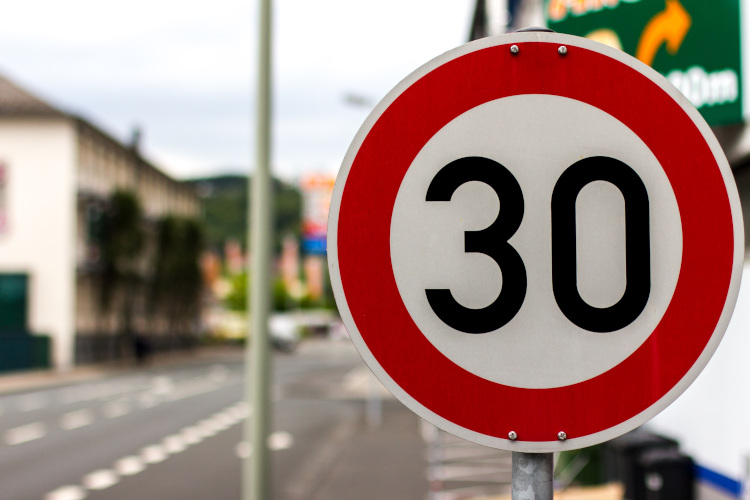

# Import Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2 as cv

# Libraries to model
import keras
from keras.models import sequential
from keras.layers.convolutional import Conv2D ,MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Clone Dataset and Exploration

In [2]:
# Clone repo containing the traffic signs dataset
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [3]:
# List files
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [5]:
# Check the labels
label = pd.read_csv('german-traffic-signs/signnames.csv')
label.tail(10)

,ClassId,SignName
33,33,Turn right ahead
34,34,Turn left ahead
35,35,Ahead only
36,36,Go straight or right
37,37,Go straight or left
38,38,Keep right
39,39,Keep left
40,40,Roundabout mandatory
41,41,End of no passing
42,42,End of no passing by vechiles over 3.5 metric ...


In [8]:
# Number of classes
label.shape

(43, 2)

In [9]:
# Load pickled dataset

# Training data
with open("german-traffic-signs/train.p",mode='rb') as training:
  train = pickle.load(training)
# Test data
with open("german-traffic-signs/test.p",mode='rb') as testing:
  test = pickle.load(testing)
# Holdout data
with open("german-traffic-signs/valid.p",mode='rb') as validation:
  valid = pickle.load(validation)

In [10]:
# Check the keys
train.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [11]:
# Create train and test sets based on features and labels
X_train , y_train = train['features'], train['labels']
X_test , y_test = test['features'], test['labels']
X_validation , y_validation = valid['features'], valid['labels']

In [12]:
# Check the shape
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


Image Label is 25


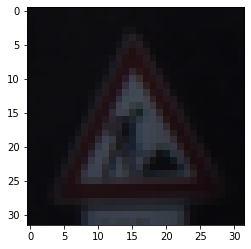

In [18]:
# Explore the dataset using one random image
random = np.random.randint(1,len(X_train))
plt.imshow(X_train[random])
print("Image Label is {}".format(y_train[random]))

# Image preprocessing

In [19]:
# Shuffle the data to prevent bias during training
from sklearn.utils import shuffle
X_train , y_train = shuffle(X_train,y_train)

In [20]:
def preprocessing(img): 
  """ Preprocess data before feeding it to the model
  Args:
      img: Image to modify
  Return:
      img: Grayed-contrast-normalized Image
  """
  # Convert rgb to grayscale
  img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  # Apply adaptive histogram equalization 
  clahe = cv.createCLAHE()
  img = clahe.apply(img)
  # Normalization
  img = img/255
  return img

In [21]:
# Preprocess data
X_train_processed = np.array(list(map(preprocessing,X_train)))
X_test_processed = np.array(list(map(preprocessing,X_test)))
X_validation_processed = np.array(list(map(preprocessing,X_validation)))

In [22]:
# Reshape data to ensure correctness
X_train_processed = X_train_processed.reshape(34799,32,32,1)
X_test_processed = X_test_processed.reshape(12630,32,32,1)
X_validation_processed = X_validation_processed.reshape(4410,32,32,1)

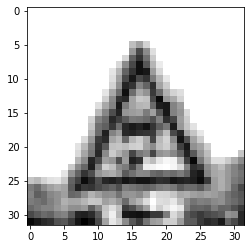

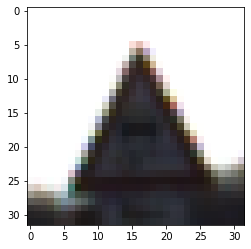

In [29]:
# Check before and after preprocessing
new_rand = np.random.randint(1,len(X_train))
# After
plt.imshow(X_train_processed[new_rand].squeeze(), cmap='gray')
plt.figure()
# Before
plt.imshow(X_train[new_rand].squeeze())

# Model

In [30]:
# Instantiate the model
model = keras.Sequential()
# Add the convolutional layer
model.add(Conv2D(32,(5,5),activation='relu',input_shape=(32,32,1)))
# Pooling layer to reduce the dimensions of the feature maps
model.add(MaxPooling2D(pool_size=(2,2)))
# Dropout layer to prevent overfitting
model.add(Dropout(0.25))
# Another convolutional layer
model.add(Conv2D(64,(5,5),activation='relu'))
# Another pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# Flatten the image to one-dimensional array
model.add(Flatten())
# Dense Layer to classify images
model.add(Dense(256,activation='relu'))
# Another dropout layer to make sure we don't get an overfitted model
model.add(Dropout(0.5))
# Ouput layer of our network
model.add(Dense(43,activation='softmax'))
# Summerize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0

In [31]:
# Compile the model
model.compile(Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [32]:
# Fit data into model based on standard parameters
model_history = model.fit(X_train_processed,
                    y_train,
                    batch_size=500,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_validation_processed,y_validation))

Epoch 1/50
70/70 [==============================] - 12s 33ms/step - loss: 3.5607 - accuracy: 0.0629 - val_loss: 3.4689 - val_accuracy: 0.1329
Epoch 2/50
70/70 [==============================] - 2s 26ms/step - loss: 3.3098 - accuracy: 0.1501 - val_loss: 3.1000 - val_accuracy: 0.3118
Epoch 3/50
70/70 [==============================] - 2s 25ms/step - loss: 2.7154 - accuracy: 0.3345 - val_loss: 2.3095 - val_accuracy: 0.4916
Epoch 4/50
70/70 [==============================] - 2s 26ms/step - loss: 2.0759 - accuracy: 0.4637 - val_loss: 1.7561 - val_accuracy: 0.5739
Epoch 5/50
70/70 [==============================] - 2s 26ms/step - loss: 1.6738 - accuracy: 0.5432 - val_loss: 1.3741 - val_accuracy: 0.6485
Epoch 6/50
70/70 [==============================] - 2s 25ms/step - loss: 1.3973 - accuracy: 0.6083 - val_loss: 1.1109 - val_accuracy: 0.6989
Epoch 7/50
70/70 [==============================] - 2s 25ms/step - loss: 1.1879 - accuracy: 0.6613 - val_loss: 0.9147 - val_accuracy: 0.7696
Epoch 8/50
7

# Evaluation

In [33]:
# Evaluate the model
score = model.evaluate(X_test_processed,y_test)
print("Test accuracy' is {}".format(score[1]))

395/395 [==============================] - 2s 4ms/step - loss: 0.1848 - accuracy: 0.9477
Test accuracy' is 0.9476643204689026


In [41]:
# Visulize the keys
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'Epochs')

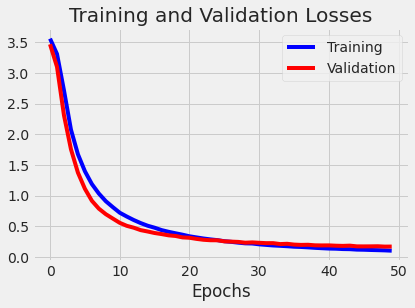

In [47]:
# Plot the losses
plt.style.use('fivethirtyeight')
plt.plot(model_history.history['loss'], 'b')
plt.plot(model_history.history['val_loss'], 'r')
plt.legend(['Training','Validation'])
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

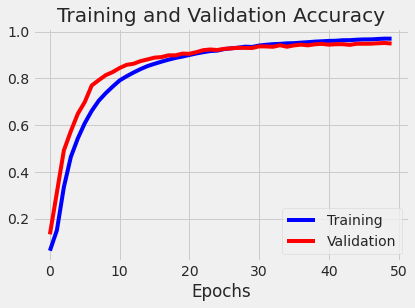

In [48]:
# Plot the accuracy
plt.style.use('fivethirtyeight')
plt.plot(model_history.history['accuracy'], 'b')
plt.plot(model_history.history['val_accuracy'], 'r')
plt.legend(['Training','Validation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')

In [35]:
# Predict
predict_x = model.predict(X_test_processed) 
classes_x = np.argmax(predict_x,axis=1)
y_true_label= y_test

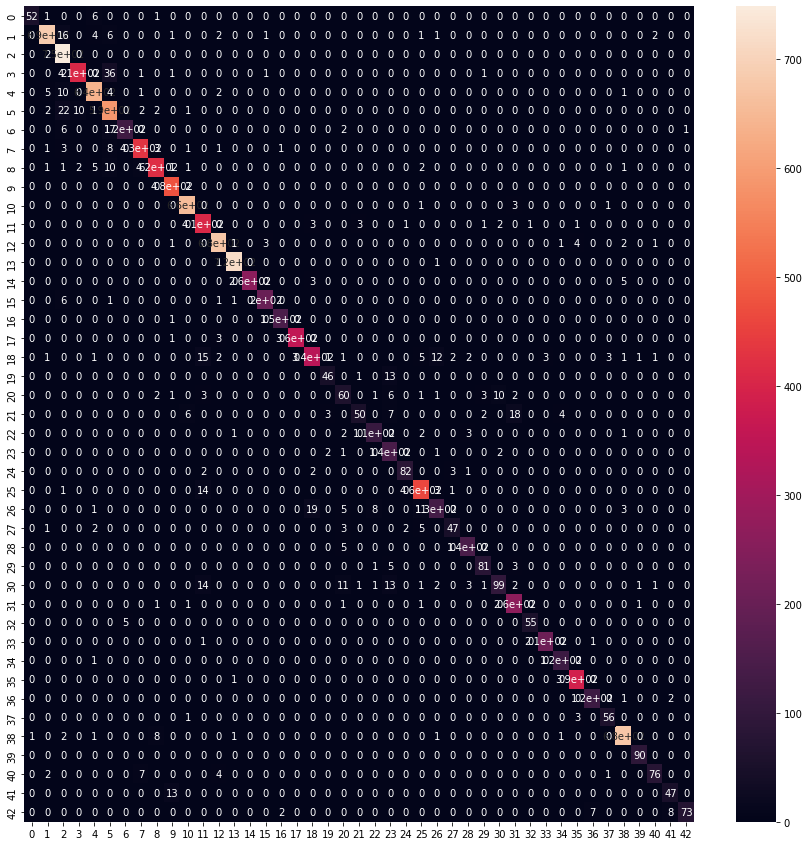

In [36]:
# See the big picture
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true_label,classes_x)
plt.figure(figsize=(15,15))
sns.heatmap(matrix,annot=True)

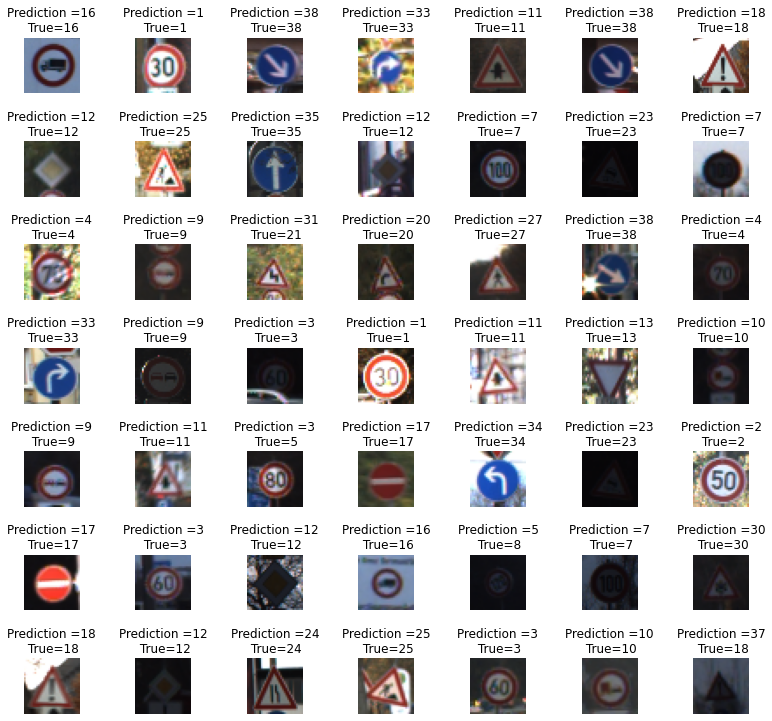

In [39]:
# Visualize the performance on our test set
L = 7
W = 7
fig , axes = plt.subplots(L,W,figsize=(13,13))
axes = axes.ravel()
for i in range(0,L*W):
  axes[i].imshow(X_test[i])
  axes[i].set_title('Prediction ={}\n True={}'.format(classes_x[i],y_true_label[i]))
  axes[i].axis('off')
plt.subplots_adjust(wspace=1)

# Save the Model

In [40]:
model.save('cnn_model.h5')